# 互评作业2：网页浏览行为关联规则挖掘
# 1120191287 林超超
## 1. 问题描述
分析用户在网站上的浏览行为数据，挖掘潜在的跳转规律，为网站提供优化导航结构的建议。

## 2. 数据集
UCI ML Repository - Anonymous Microsoft Web Data
http://archive.ics.uci.edu/ml/datasets/Anonymous+Microsoft+Web+Data

## 3. 关联规则挖掘
### 3.1 数据预处理
·清洗数据

·处理缺失值

·提取用户浏览记录

### 3.2  数据探索性分析
·分析最常被访问的页面、页面访问量分布等

### 3.3 关联规则挖掘
·使用Apriori算法或FP-growth算法，根据用户浏览记录计算频繁项集和关联规则。

### 3.4 结果评估
·计算关联规则的支持度、置信度和提升度，得出强关联规则。

### 3.5 结果分析与应用
·分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。

## 数据集 UCI ML Repository - Anonymous Microsoft Web Data

In [28]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


### 1. 数据预处理
#### 1.1 提取用户浏览记录和属性数据

In [8]:
df_user = pd.read_csv("./anonymous/anonymous-msweb.data",header=None,skiprows=range(0,301), names=['marks', 'ID','ignored'])
df_user.head()

,marks,ID,ignored
0,C,10001,10001
1,V,1000,1
2,V,1001,1
3,V,1002,1
4,C,10002,10002


In [3]:
df_attribute = pd.read_csv('./anonymous/anonymous-msweb.data',header=None,skiprows=range(0,7),nrows=293, names=['marks', 'ID','ignored','title','url'])
df_attribute.head()

,marks,ID,ignored,title,url
0,A,1287,1,International AutoRoute,/autoroute
1,A,1288,1,library,/library
2,A,1289,1,Master Chef Product Information,/masterchef
3,A,1297,1,Central America,/centroam
4,A,1215,1,For Developers Only Info,/developer


#### 1.2 查看缺失值

In [4]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131365 entries, 0 to 131364
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   marks    131365 non-null  object
 1   ID       131365 non-null  int64 
 2   ignored  131365 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.0+ MB


In [5]:
df_attribute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   marks    293 non-null    object
 1   ID       293 non-null    int64 
 2   ignored  293 non-null    int64 
 3   title    293 non-null    object
 4   url      293 non-null    object
dtypes: int64(2), object(3)
memory usage: 11.6+ KB


没有缺失值不做处理

#### 1.3 数据清洗
对于用户浏览记录：

marks列是标记，C表示案例行，ID列表示用户的案例ID号；V表示投票行，则ID列表示用户访问过的网址的属性ID

ignored列可以被忽略

因此将该表处理为用户列user，和用户访问过的网址列visit

In [39]:
users = []
visits = []
v = None
for i, row in df_user.iterrows():
    if row['marks']=='C':
        if v!= None:
            visits.append(v)
        users.append(row['ID'])
        v=[]
    else:
        v.append(row['ID'])
visits.append(v)
df_user_visit = pd.DataFrame({"user":users,"visit":visits})
df_user_visit.head()

,user,visit
0,10001,"[1000, 1001, 1002]"
1,10002,"[1001, 1003]"
2,10003,"[1001, 1003, 1004]"
3,10004,[1005]
4,10005,[1006]


对于属性数据：

marks列是标记，这里全部为A，是无用列

ignored列可以被忽略

删除无用列marks和ignored

In [7]:
del df_attribute['marks'], df_attribute['ignored']
df_attribute.head()

,ID,title,url
0,1287,International AutoRoute,/autoroute
1,1288,library,/library
2,1289,Master Chef Product Information,/masterchef
3,1297,Central America,/centroam
4,1215,For Developers Only Info,/developer


### 2. 探索性分析
#### 2.1 分析页面访问量分布
统计每个页面被访问的数量

In [33]:
times = Counter(df_user[df_user['marks'] == 'V']['ID'])
df_times = pd.DataFrame(times.items(), columns=['ID','times'])
df_times.head()

,ID,times
0,1000,912
1,1001,4451
2,1002,749
3,1003,2968
4,1004,8463


计算所有页面访问量的数值属性，给出5数概括

In [34]:
df_times['times'].describe()

count      285.000000
mean       346.154386
std       1171.189066
min          1.000000
25%         10.000000
50%         46.000000
75%        187.000000
max      10836.000000
Name: times, dtype: float64

绘制网页访问量柱状图

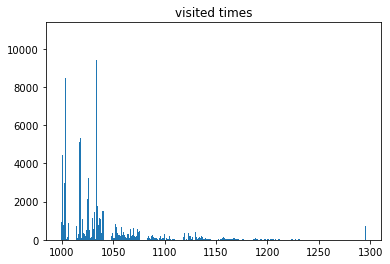

In [35]:
plt.title('visited times')    
plt.bar(df_times['ID'], df_times['times'])
plt.show()

可见网页访问主要集中在属性ID为1000-1050之间的网页

#### 2.2 分析最常被访问的页面

In [36]:
df_times.sort_values("times", inplace=True, ascending=[False])
df_times=pd.merge(df_times, df_attribute, on="ID")
df_times.head()

,ID,times,title,url
0,1008,10836,Free Downloads,/msdownload
1,1034,9383,Internet Explorer,/ie
2,1004,8463,Microsoft.com Search,/search
3,1018,5330,isapi,/isapi
4,1017,5108,Products,/products


可见访问最多的是Free Downloads网页，被浏览了10836次

其次是Internet Explorer、Microsoft.com Search、isapi、Products

### 3. 关联规则挖掘
#### 3.1 Apriori算法
Apriori原理：如果一个项集是频繁的，那么它的子项集一定也是频繁的；如果一个项集不是频繁的，那么它的父项集也一定不是频繁的。

In [37]:
'''
    1、发现频繁项集
'''
# 生成单一元素的项集
def create_C1():
    C1 = set()
    for transaction in dataSet:
        for item in transaction:
            C1.add(frozenset([item])) # 每条交易记录中的单个商品
    return C1 # {frozenset({'l1'}), frozenset({'l2'}), frozenset({'l3'}), frozenset({'l4'}), frozenset({'l5'})}

# 频繁项集组合
def create_Ck(Lk, k):
    """

    :param Lk: 包含了k-1个元素的频繁项集
    :param k:
    :return: Ck: 包含了k个元素的频繁项集
    """
    Ck = set()
    len_Lk = len(Lk)
    list_Lk = list(Lk)
    for i in range(len_Lk):
        for j in range(1, len_Lk):
            L1 = list(list_Lk[i])
            L2 = list(list_Lk[j])
            L1.sort()
            L2.sort()
            # 前k-2项相同时，将两个集合合并
            if L1[0:k-2] == L2[0:k-2]:
                Ck_item = list_Lk[i] | list_Lk[j]
                if is_apriori(Ck_item, Lk):
                    Ck.add(Ck_item)
    return Ck

# 判断是否满足Apriori原理
def is_apriori(Ck_item, Lk):
    """

    :param Ck: 包含了k个元素的可能频繁项集
    :param Lk: 包含了k-1个元素的频繁项集
    :return: bool, 是否满足Apriori原理
    """
    for item in Ck_item:
        sub_Ck = Ck_item - frozenset([item])
        if sub_Ck not in Lk:
            return False
    return True

def generate_Lk_by_Ck(Ck, minSupport=0.5):
    Lk = set()
    item_count = {}

    for t in dataSet:
        for item in Ck:
            if item.issubset(t):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1
    # 计算支持度
    for item in item_count:
        support = item_count[item] / float(len(dataSet))
        if support >= minSupport:
            Lk.add(item)
            supportData[item] = support

    return Lk

def generate_L(minSupport):
    C1 = create_C1()
    L1 = generate_Lk_by_Ck(C1, minSupport)

    L = []
    Lksub1 = L1.copy()
    L.append(Lksub1)
    for lk in Lksub1:
        freq_itemsets.append((lk, supportData[lk]))
    i = 2

    while True:
        Ci = create_Ck(Lksub1, i)
        Li = generate_Lk_by_Ck(Ci, minSupport)
        Lksub1 = Li.copy()
        if len(Lksub1) == 0:
            break
        L.append(Lksub1)
        for lk in Lksub1:
            freq_itemsets.append((lk, supportData[lk]))
        i += 1

    return L, freq_itemsets


'''
    2、找出关联规则
'''
def generate_rules(L, minSupport):
    big_rule_list = []
    sub_set_list = []
    for i in range(0, len(L)):
        for freq_set in L[i]:
            for sub_set in sub_set_list:
                if sub_set.issubset(freq_set):
                    support = supportData[freq_set] / supportData[freq_set - sub_set]
                    big_rule = (freq_set - sub_set, sub_set, support)
                    if support >= minSupport and big_rule not in big_rule_list:
                        big_rule_list.append(big_rule)
            sub_set_list.append(freq_set)
    return big_rule_list

In [41]:
supportData = {}
freq_itemsets = []
dataSet = df_user_visit['visit']

#### 3.2 计算频繁项集
使用Apriori算法根据用户浏览记录计算频繁项集，选择最小支持度为0.1

In [46]:
L, _ = generate_L(minSupport=0.1)
big_rule_list = generate_rules(L, minSupport=0.1)

In [52]:
for Lk in L:
    print("="*50)
    print("frequent " + str(len(list(Lk)[0])) + "-itemsets\t\tsupport")
    print("="*50)
    for freq_set in Lk:
        print(freq_set)

frequent 1-itemsets		support
frozenset({1004})
frozenset({1009})
frozenset({1008})
frozenset({1034})
frozenset({1001})
frozenset({1018})
frozenset({1017})
frequent 2-itemsets		support
frozenset({1008, 1034})


#### 3.3 计算关联规则。
使用Apriori根据用户浏览记录计算关联规则

In [53]:
print("Big Rules")
for item in big_rule_list:
    print(item[0], " => ", item[1])

Big Rules
frozenset({1034})  =>  frozenset({1008})
frozenset({1008})  =>  frozenset({1034})


### 4. 结果评估
#### 4.1 关联规则的支持度、置性度、提升度
输出关联规则的支持度、置信度和提升度

In [81]:
# supportData[]
for item in big_rule_list:
    a = list(item[0])
    a.append(list(item[1])[0])
    a = frozenset(a)
    print(item[0], " => ", item[1], " support: ", supportData[a], " confidence: ", item[2], " lifting: ", item[2] / supportData[a])

frozenset({1034})  =>  frozenset({1008})  support:  0.16080217663782825  confidence:  0.5605882979857189  lifting:  3.486198443994458
frozenset({1008})  =>  frozenset({1034})  support:  0.16080217663782825  confidence:  0.4854189737910668  lifting:  3.0187338501291987


关联规则{1008 -> 1034}的支持度为0.16080217663782825，置信度为0.5605882979857189，提升度为3.486198443994458

关联规则{1008 -> 1034}的支持度为0.16080217663782825，置信度为0.4854189737910668，提升度为3.0187338501291987

因此{1008 -> 1034}和{1034 -> 1008}为强关联规则

### 5. 结果分析与应用
分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。

根据得到的强关联规则，建议在1008和1034代表的网站建立两个站点互相的导航，使用户能够方便快捷的跳转网站。